<!--NAVIGATION-->
< [Three-Dimensional Plotting in Matplotlib](04.12-Three-Dimensional-Plotting.ipynb) | [Contents](Index.ipynb) | [Visualization with Seaborn](04.14-Visualization-With-Seaborn.ipynb) >

# Geographic Data with Basemap

One common type of visualization in data science is that of geographic data.
Matplotlib's main tool for this type of visualization is the Basemap toolkit, which is one of several Matplotlib toolkits which lives under the ``mpl_toolkits`` namespace.
Admittedly, Basemap feels a bit clunky to use, and often even simple visualizations take much longer to render than you might hope.
More modern solutions such as leaflet or the Google Maps API may be a better choice for more intensive map visualizations.
Still, Basemap is a useful tool for Python users to have in their virtual toolbelts.
In this section, we'll show several examples of the type of map visualization that is possible with this toolkit.

Installation of Basemap is straightforward; if you're using conda you can type this and the package will be downloaded:

```
$ conda install basemap
```

We add just a single new import to our standard boilerplate:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

Once you have the Basemap toolkit installed and imported, geographic plots are just a few lines away (the graphics in the following also requires the ``PIL`` package in Python 2, or the ``pillow`` package in Python 3):

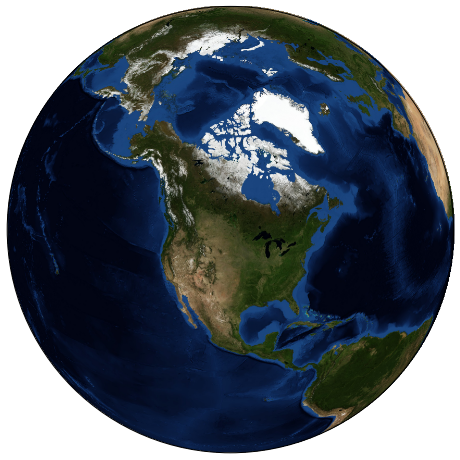

In [2]:
plt.figure(figsize=(8, 8))
m = Basemap(projection='ortho', resolution=None, lat_0=50, lon_0=-100)
m.bluemarble(scale=0.5);

The meaning of the arguments to ``Basemap`` will be discussed momentarily.

The useful thing is that the globe shown here is not a mere image; it is a fully-functioning Matplotlib axes that understands spherical coordinates and which allows us to easily overplot data on the map!
For example, we can use a different map projection, zoom-in to North America and plot the location of Seattle.
We'll use an etopo image (which shows topographical features both on land and under the ocean) as the map background:

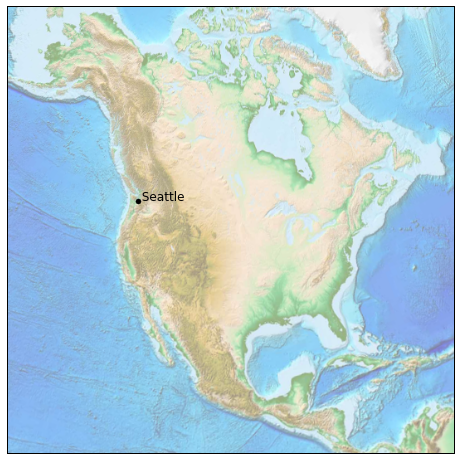

In [3]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution=None,
            width=8E6, height=8E6, 
            lat_0=45, lon_0=-100,)
m.etopo(scale=0.5, alpha=0.5)

# Map (long, lat) to (x, y) for plotting
x, y = m(-122.3, 47.6)
plt.plot(x, y, 'ok', markersize=5)
plt.text(x, y, ' Seattle', fontsize=12);

This gives you a brief glimpse into the sort of geographic visualizations that are possible with just a few lines of Python.
We'll now discuss the features of Basemap in more depth, and provide several examples of visualizing map data.
Using these brief examples as building blocks, you should be able to create nearly any map visualization that you desire.

## Map Projections

The first thing to decide when using maps is what projection to use.
You're probably familiar with the fact that it is impossible to project a spherical map, such as that of the Earth, onto a flat surface without somehow distorting it or breaking its continuity.
These projections have been developed over the course of human history, and there are a lot of choices!
Depending on the intended use of the map projection, there are certain map features (e.g., direction, area, distance, shape, or other considerations) that are useful to maintain.

The Basemap package implements several dozen such projections, all referenced by a short format code.
Here we'll briefly demonstrate some of the more common ones.

We'll start by defining a convenience routine to draw our world map along with the longitude and latitude lines:

In [4]:
from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

### Cylindrical projections

The simplest of map projections are cylindrical projections, in which lines of constant latitude and longitude are mapped to horizontal and vertical lines, respectively.
This type of mapping represents equatorial regions quite well, but results in extreme distortions near the poles.
The spacing of latitude lines varies between different cylindrical projections, leading to different conservation properties, and different distortion near the poles.
In the following figure we show an example of the *equidistant cylindrical projection*, which chooses a latitude scaling that preserves distances along meridians.
Other cylindrical projections are the Mercator (``projection='merc'``) and the cylindrical equal area (``projection='cea'``) projections.

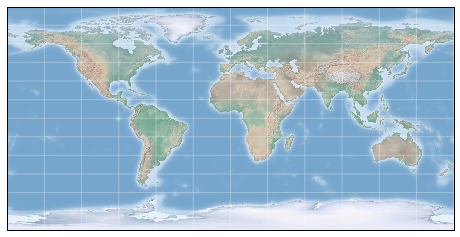

In [5]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
draw_map(m)

The additional arguments to Basemap for this view specify the latitude (``lat``) and longitude (``lon``) of the lower-left corner (``llcrnr``) and upper-right corner (``urcrnr``) for the desired map, in units of degrees.

### Pseudo-cylindrical projections

Pseudo-cylindrical projections relax the requirement that meridians (lines of constant longitude) remain vertical; this can give better properties near the poles of the projection.
The Mollweide projection (``projection='moll'``) is one common example of this, in which all meridians are elliptical arcs.
It is constructed so as to preserve area across the map: though there are distortions near the poles, the area of small patches reflects the true area.
Other pseudo-cylindrical projections are the sinusoidal (``projection='sinu'``) and Robinson (``projection='robin'``) projections.

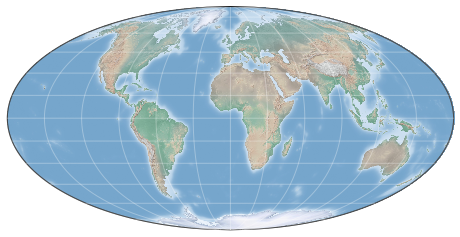

In [6]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='moll', resolution=None,
            lat_0=0, lon_0=0)
draw_map(m)

The extra arguments to Basemap here refer to the central latitude (``lat_0``) and longitude (``lon_0``) for the desired map.

### Perspective projections

Perspective projections are constructed using a particular choice of perspective point, similar to if you photographed the Earth from a particular point in space (a point which, for some projections, technically lies within the Earth!).
One common example is the orthographic projection (``projection='ortho'``), which shows one side of the globe as seen from a viewer at a very long distance. As such, it can show only half the globe at a time.
Other perspective-based projections include the gnomonic projection (``projection='gnom'``) and stereographic projection (``projection='stere'``).
These are often the most useful for showing small portions of the map.

Here is an example of the orthographic projection:

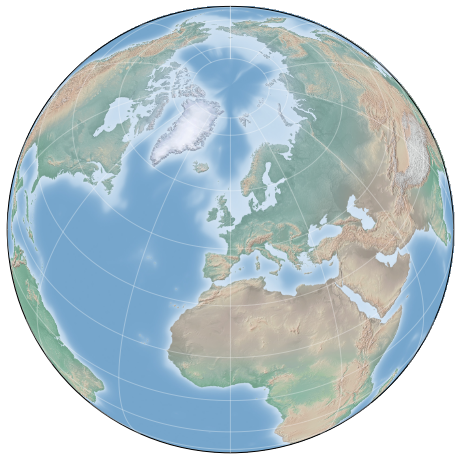

In [7]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='ortho', resolution=None,
            lat_0=50, lon_0=0)
draw_map(m);

### Conic projections

A Conic projection projects the map onto a single cone, which is then unrolled.
This can lead to very good local properties, but regions far from the focus point of the cone may become very distorted.
One example of this is the Lambert Conformal Conic projection (``projection='lcc'``), which we saw earlier in the map of North America.
It projects the map onto a cone arranged in such a way that two standard parallels (specified in Basemap by ``lat_1`` and ``lat_2``) have well-represented distances, with scale decreasing between them and increasing outside of them.
Other useful conic projections are the equidistant conic projection (``projection='eqdc'``) and the Albers equal-area projection (``projection='aea'``).
Conic projections, like perspective projections, tend to be good choices for representing small to medium patches of the globe.

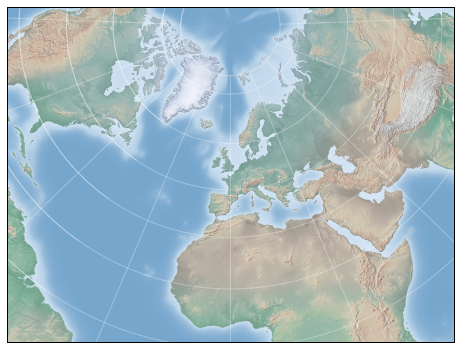

In [8]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution=None,
            lon_0=0, lat_0=50, lat_1=45, lat_2=55,
            width=1.6E7, height=1.2E7)
draw_map(m)

### Other projections

If you're going to do much with map-based visualizations, I encourage you to read up on other available projections, along with their properties, advantages, and disadvantages.
Most likely, they are available in the [Basemap package](http://matplotlib.org/basemap/users/mapsetup.html).
If you dig deep enough into this topic, you'll find an incredible subculture of geo-viz geeks who will be ready to argue fervently in support of their favorite projection for any given application! 

## Drawing a Map Background

Earlier we saw the ``bluemarble()`` and ``shadedrelief()`` methods for projecting global images on the map, as well as the ``drawparallels()`` and ``drawmeridians()`` methods for drawing lines of constant latitude and longitude.
The Basemap package contains a range of useful functions for drawing borders of physical features like continents, oceans, lakes, and rivers, as well as political boundaries such as countries and US states and counties.
The following are some of the available drawing functions that you may wish to explore using IPython's help features:

- **Physical boundaries and bodies of water**
  - ``drawcoastlines()``: Draw continental coast lines
  - ``drawlsmask()``: Draw a mask between the land and sea, for use with projecting images on one or the other
  - ``drawmapboundary()``: Draw the map boundary, including the fill color for oceans.
  - ``drawrivers()``: Draw rivers on the map
  - ``fillcontinents()``: Fill the continents with a given color; optionally fill lakes with another color

- **Political boundaries**
  - ``drawcountries()``: Draw country boundaries
  - ``drawstates()``: Draw US state boundaries
  - ``drawcounties()``: Draw US county boundaries

- **Map features**
  - ``drawgreatcircle()``: Draw a great circle between two points
  - ``drawparallels()``: Draw lines of constant latitude
  - ``drawmeridians()``: Draw lines of constant longitude
  - ``drawmapscale()``: Draw a linear scale on the map

- **Whole-globe images**
  - ``bluemarble()``: Project NASA's blue marble image onto the map
  - ``shadedrelief()``: Project a shaded relief image onto the map
  - ``etopo()``: Draw an etopo relief image onto the map
  - ``warpimage()``: Project a user-provided image onto the map

For the boundary-based features, you must set the desired resolution when creating a Basemap image.
The ``resolution`` argument of the ``Basemap`` class sets the level of detail in boundaries, either ``'c'`` (crude), ``'l'`` (low), ``'i'`` (intermediate), ``'h'`` (high), ``'f'`` (full), or ``None`` if no boundaries will be used.
This choice is important: setting high-resolution boundaries on a global map, for example, can be *very* slow.

Here's an example of drawing land/sea boundaries, and the effect of the resolution parameter.
We'll create both a low- and high-resolution map of Scotland's beautiful Isle of Skye.
It's located at 57.3°N, 6.2°W, and a map of 90,000 × 120,000 kilometers shows it well:

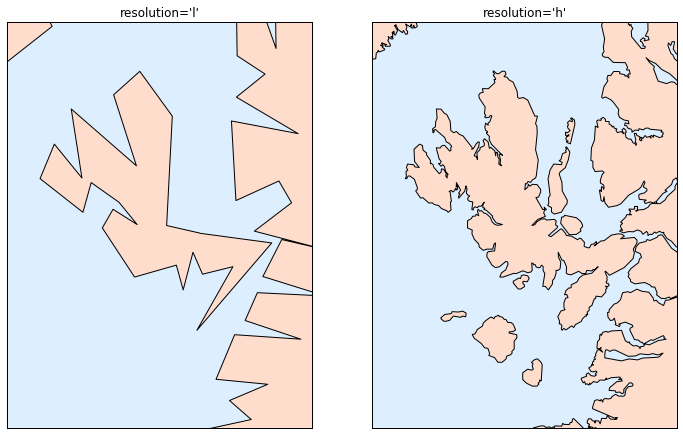

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

for i, res in enumerate(['l', 'h']):
    m = Basemap(projection='gnom', lat_0=57.3, lon_0=-6.2,
                width=90000, height=120000, resolution=res, ax=ax[i])
    m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF')
    m.drawmapboundary(fill_color="#DDEEFF")
    m.drawcoastlines()
    ax[i].set_title("resolution='{0}'".format(res));

Notice that the low-resolution coastlines are not suitable for this level of zoom, while high-resolution works just fine.
The low level would work just fine for a global view, however, and would be *much* faster than loading the high-resolution border data for the entire globe!
It might require some experimentation to find the correct resolution parameter for a given view: the best route is to start with a fast, low-resolution plot and increase the resolution as needed.

## Plotting Data on Maps

Perhaps the most useful piece of the Basemap toolkit is the ability to over-plot a variety of data onto a map background.
For simple plotting and text, any ``plt`` function works on the map; you can use the ``Basemap`` instance to project latitude and longitude coordinates to ``(x, y)`` coordinates for plotting with ``plt``, as we saw earlier in the Seattle example.

In addition to this, there are many map-specific functions available as methods of the ``Basemap`` instance.
These work very similarly to their standard Matplotlib counterparts, but have an additional Boolean argument ``latlon``, which if set to ``True`` allows you to pass raw latitudes and longitudes to the method, rather than projected ``(x, y)`` coordinates.

Some of these map-specific methods are:

- ``contour()``/``contourf()`` : Draw contour lines or filled contours
- ``imshow()``: Draw an image
- ``pcolor()``/``pcolormesh()`` : Draw a pseudocolor plot for irregular/regular meshes
- ``plot()``: Draw lines and/or markers.
- ``scatter()``: Draw points with markers.
- ``quiver()``: Draw vectors.
- ``barbs()``: Draw wind barbs.
- ``drawgreatcircle()``: Draw a great circle.

We'll see some examples of a few of these as we continue.
For more information on these functions, including several example plots, see the [online Basemap documentation](http://matplotlib.org/basemap/).

## Example: California Cities

Recall that in [Customizing Plot Legends](04.06-Customizing-Legends.ipynb), we demonstrated the use of size and color in a scatter plot to convey information about the location, size, and population of California cities.
Here, we'll create this plot again, but using Basemap to put the data in context.

We start with loading the data, as we did before:

In [10]:
import pandas as pd
cities = pd.read_csv('data/california_cities.csv')

# Extract the data we're interested in
lat = cities['latd'].values
lon = cities['longd'].values
population = cities['population_total'].values
area = cities['area_total_km2'].values

Next, we set up the map projection, scatter the data, and then create a colorbar and legend:

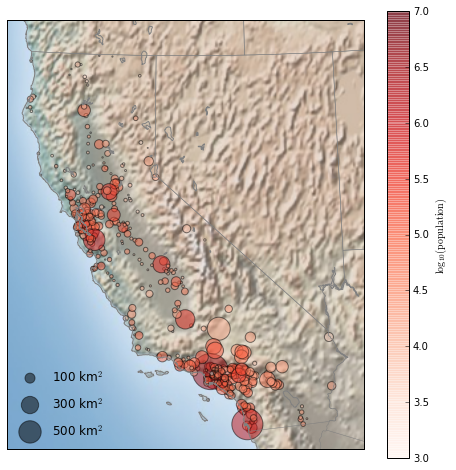

In [11]:
# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=37.5, lon_0=-119,
            width=1E6, height=1.2E6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=np.log10(population), s=area,
          cmap='Reds', alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm population})$')
plt.clim(3, 7)

# make legend with dummy points
for a in [100, 300, 500]:
    plt.scatter([], [], c='k', alpha=0.5, s=a,
                label=str(a) + ' km$^2$')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

This shows us roughly where larger populations of people have settled in California: they are clustered near the coast in the Los Angeles and San Francisco areas, stretched along the highways in the flat central valley, and avoiding almost completely the mountainous regions along the borders of the state.

## Example: Surface Temperature Data

As an example of visualizing some more continuous geographic data, let's consider the "polar vortex" that hit the eastern half of the United States in January of 2014.
A great source for any sort of climatic data is [NASA's Goddard Institute for Space Studies](http://data.giss.nasa.gov/).
Here we'll use the GIS 250 temperature data, which we can download using shell commands (these commands may have to be modified on Windows machines).
The data used here was downloaded on 6/12/2016, and the file size is approximately 9MB:

In [12]:
# !curl -O http://data.giss.nasa.gov/pub/gistemp/gistemp250.nc.gz
# !gunzip gistemp250.nc.gz

The data comes in NetCDF format, which can be read in Python by the ``netCDF4`` library.
You can install this library as shown here

```
$ conda install netcdf4
```

We read the data as follows:

In [13]:
from netCDF4 import Dataset
data = Dataset('gistemp250.nc')

The file contains many global temperature readings on a variety of dates; we need to select the index of the date we're interested in—in this case, January 15, 2014:

In [14]:
from netCDF4 import date2index
from datetime import datetime
timeindex = date2index(datetime(2014, 1, 15),
                       data.variables['time'])

Now we can load the latitude and longitude data, as well as the temperature anomaly for this index:

In [15]:
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]
lon, lat = np.meshgrid(lon, lat)
temp_anomaly = data.variables['tempanomaly'][timeindex]

Finally, we'll use the ``pcolormesh()`` method to draw a color mesh of the data.
We'll look at North America, and use a shaded relief map in the background.
Note that for this data we specifically chose a divergent colormap, which has a neutral color at zero and two contrasting colors at negative and positive values.
We'll also lightly draw the coastlines over the colors for reference:

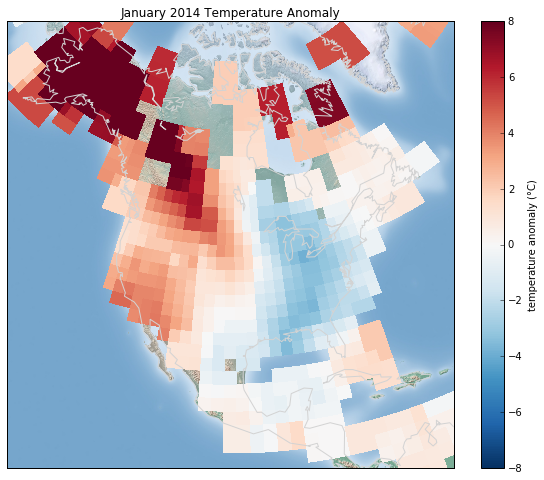

In [16]:
fig = plt.figure(figsize=(10, 8))
m = Basemap(projection='lcc', resolution='c',
            width=8E6, height=8E6, 
            lat_0=45, lon_0=-100,)
m.shadedrelief(scale=0.5)
m.pcolormesh(lon, lat, temp_anomaly,
             latlon=True, cmap='RdBu_r')
plt.clim(-8, 8)
m.drawcoastlines(color='lightgray')

plt.title('January 2014 Temperature Anomaly')
plt.colorbar(label='temperature anomaly (°C)');

The data paints a picture of the localized, extreme temperature anomalies that happened during that month.
The eastern half of the United States was much colder than normal, while the western half and Alaska were much warmer.
Regions with no recorded temperature show the map background.

<!--NAVIGATION-->
< [Three-Dimensional Plotting in Matplotlib](04.12-Three-Dimensional-Plotting.ipynb) | [Contents](Index.ipynb) | [Visualization with Seaborn](04.14-Visualization-With-Seaborn.ipynb) >